In [145]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np
import math

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import scipy.signal as sl
from typing import Optional
import scipy as sp
import sys
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.experimental.models import SPIRIT
from deepmeg.data.datasets import EpochsDataset, read_epochs_dataset
from torch.utils.data import DataLoader
from deepmeg.preprocessing.transforms import zscore
import torch
from collections import defaultdict
import torchmetrics
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.experimental.interpreters import SPIRITInterpreter
import random
import torch.nn as nn
from deepmeg.models.interpretable import BaseModel


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

def accuracy(predictions, targets):

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy


In [233]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
info = mne.io.read_raw_fif(fname_raw).resample(600).pick_types(meg='grad').info

In [146]:
dataset = read_epochs_dataset('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
x, y = next(iter(DataLoader(test, len(test))))
y.shape

kwargs = dict(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    filter_size=50,
    n_latent=8,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

In [115]:
class LFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = self.temp_conv(x.permute(0, -1, 1))
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

model = LFCNN(204, 301, 8, 50, 10, 8)
model(X)

tensor([[ 0.0364,  0.0650, -0.2147,  0.0265,  0.0381, -0.0090,  0.0497, -0.0784]],
       grad_fn=<AddmmBackward0>)

In [117]:
model.temp_conv.weight.shape

torch.Size([8, 1, 50])

In [33]:
next(model.named_parameters())[1].shape

torch.Size([8, 204])

In [75]:
import torch
import torch.nn as nn
from scipy.signal.windows import get_window
from deepmeg.training.trainers import Trainer

class WeightClipper(object):
    def __init__(self, model, window):
        self.model = model
        self.window = torch.permute(torch.tensor(window)[:, None, None].repeat(1, 1, self.model.n_latent), (2, 1, 0))

    def __call__(self, module):
        self.model.temp_conv.weight *= self.window


class TempConvWinClipping(Callback):
    def __init__(self, window_function='hamming'):
        super().__init__()
        self.window_function = window_function

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.clipper = WeightClipper(self.model, get_window(self.window_function, self.model.temp_conv.weight.shape[-1], fftbins=False))

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.model.apply(self.clipper)


In [52]:
model.temp_conv.weight.shape

torch.Size([8, 1, 50])

In [76]:
model = LFCNN(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        TempConvWinClipping(),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [62]:
model.trainer.callbacks[1].clipper.window.shape

torch.Size([8, 1, 50])

Epoch 0:  loss_train:  0.1310   |    accuracy_train:  0.9604   |    loss_val:  0.1465   |    accuracy_val:  0.9122
Epoch 1:  loss_train:  0.1297   |    accuracy_train:  0.9638   |    loss_val:  0.1467   |    accuracy_val:  0.9122
Epoch 2:  loss_train:  0.1278   |    accuracy_train:  0.9654   |    loss_val:  0.1472   |    accuracy_val:  0.9177
Epoch 3:  loss_train:  0.1257   |    accuracy_train:  0.9654   |    loss_val:  0.1480   |    accuracy_val:  0.9122
Epoch 4:  loss_train:  0.1237   |    accuracy_train:  0.9671   |    loss_val:  0.1489   |    accuracy_val:  0.9122
Epoch 5:  loss_train:  0.1218   |    accuracy_train:  0.9736   |    loss_val:  0.1499   |    accuracy_val:  0.9066
Epoch 6:  loss_train:  0.1201   |    accuracy_train:  0.9769   |    loss_val:  0.1509   |    accuracy_val:  0.9066
Epoch 7:  loss_train:  0.1185   |    accuracy_train:  0.9786   |    loss_val:  0.1519   |    accuracy_val:  0.9011
Epoch 8:  loss_train:  0.1170   |    accuracy_train:  0.9817   |    loss_val:  0

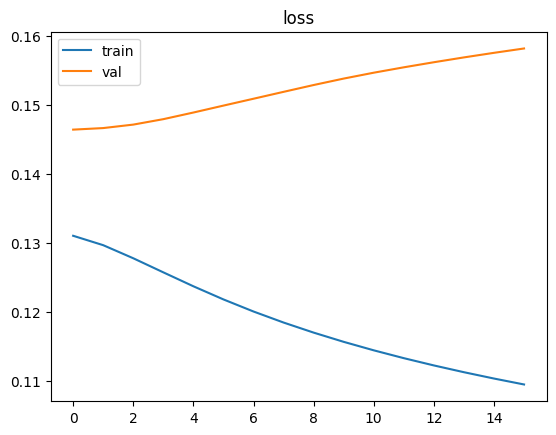

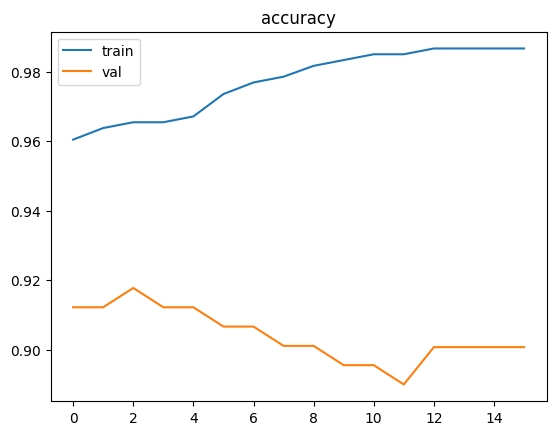

In [79]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [80]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.14120041443543
train_accuracy: 0.9410839189182628
loss: 0.21824647215279666
accuracy: 0.7597402605143461


In [15]:
from scipy.signal._fir_filter_design import _get_fs, kaiser_atten, kaiser_beta
import operator
from scipy.signal.windows import get_window
from scipy.special import sinc
import scipy as sp
import numpy as np

In [78]:
def firwin(numtaps, cutoff, width=None, window='hamming', pass_zero=True,
           scale=True, nyq=None, fs=None):

    nyq = 0.5 * _get_fs(fs, nyq)

    cutoff = np.atleast_1d(cutoff) / float(nyq)

    # Check for invalid input.
    if cutoff.ndim > 1:
        raise ValueError("The cutoff argument must be at most "
                         "one-dimensional.")
    if cutoff.size == 0:
        raise ValueError("At least one cutoff frequency must be given.")
    if cutoff.min() <= 0 or cutoff.max() >= 1:
        raise ValueError("Invalid cutoff frequency: frequencies must be "
                         "greater than 0 and less than fs/2.")
    if np.any(np.diff(cutoff) <= 0):
        raise ValueError("Invalid cutoff frequencies: the frequencies "
                         "must be strictly increasing.")

    if width is not None:
        # A width was given.  Find the beta parameter of the Kaiser window
        # and set `window`.  This overrides the value of `window` passed in.
        atten = kaiser_atten(numtaps, float(width) / nyq)
        beta = kaiser_beta(atten)
        window = ('kaiser', beta)

    if isinstance(pass_zero, str):
        if pass_zero in ('bandstop', 'lowpass'):
            if pass_zero == 'lowpass':
                if cutoff.size != 1:
                    raise ValueError('cutoff must have one element if '
                                     'pass_zero=="lowpass", got %s'
                                     % (cutoff.shape,))
            elif cutoff.size <= 1:
                raise ValueError('cutoff must have at least two elements if '
                                 'pass_zero=="bandstop", got %s'
                                 % (cutoff.shape,))
            pass_zero = True
        elif pass_zero in ('bandpass', 'highpass'):
            if pass_zero == 'highpass':
                if cutoff.size != 1:
                    raise ValueError('cutoff must have one element if '
                                     'pass_zero=="highpass", got %s'
                                     % (cutoff.shape,))
            elif cutoff.size <= 1:
                raise ValueError('cutoff must have at least two elements if '
                                 'pass_zero=="bandpass", got %s'
                                 % (cutoff.shape,))
            pass_zero = False
        else:
            raise ValueError('pass_zero must be True, False, "bandpass", '
                             '"lowpass", "highpass", or "bandstop", got '
                             '{}'.format(pass_zero))
    pass_zero = bool(operator.index(pass_zero))  # ensure bool-like

    pass_nyquist = bool(cutoff.size & 1) ^ pass_zero
    if pass_nyquist and numtaps % 2 == 0:
        raise ValueError("A filter with an even number of coefficients must "
                         "have zero response at the Nyquist frequency.")

    # Insert 0 and/or 1 at the ends of cutoff so that the length of cutoff
    # is even, and each pair in cutoff corresponds to passband.
    cutoff = np.hstack(([0.0] * pass_zero, cutoff, [1.0] * pass_nyquist))

    # `bands` is a 2-D array; each row gives the left and right edges of
    # a passband.
    bands = cutoff.reshape(-1, 2)
    print(bands*float(nyq), '->', bands)

    # Build up the coefficients.
    alpha = 0.5 * (numtaps - 1)
    m = np.arange(0, numtaps) - alpha
    h = 0
    for left, right in bands:
        h += right * sinc(right * m)
        h -= left * sinc(left * m)

    # Get and apply the window function.
    win = get_window(window, numtaps, fftbins=False)
    print(h.mean(), (h * win).mean(), h.min(), h.max())
    print(h)
    h *= win

    # Now handle scaling if desired.
    if scale:
        # Get the first passband.
        left, right = bands[0]
        if left == 0:
            scale_frequency = 0.0
        elif right == 1:
            scale_frequency = 1.0
        else:
            scale_frequency = 0.5 * (left + right)
        c = np.cos(np.pi * m * scale_frequency)
        s = np.sum(h * c)
        h /= s

    return h

In [85]:
f = 1, 90
numtaps=50
taps = firwin(numtaps, f, fs=200, pass_zero=False)

[[ 1. 90.]] -> [[0.01 0.9 ]]
0.010335475112489848 0.01477655131661303 -0.19907375617821532 0.6187823377882342
[-0.00700903 -0.01526537  0.0008157  -0.02244824  0.00601323 -0.02550876
  0.00588415 -0.02236546 -0.00079998 -0.01282202 -0.01309184  0.00100152
 -0.02775128  0.0148784  -0.03976163  0.02324158 -0.04324819  0.02010281
 -0.0321629  -0.00089674  0.00109875 -0.05126834  0.08004191 -0.19907376
  0.61878234  0.61878234 -0.19907376  0.08004191 -0.05126834  0.00109875
 -0.00089674 -0.0321629   0.02010281 -0.04324819  0.02324158 -0.03976163
  0.0148784  -0.02775128  0.00100152 -0.01309184 -0.01282202 -0.00079998
 -0.02236546  0.00588415 -0.02550876  0.00601323 -0.02244824  0.0008157
 -0.01526537 -0.00700903]


In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.signal import get_window
import math

class FIRConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, window='hamming'):
        super().__init__()
        self.conv_params = {
            "in_channels": in_channels,
            "out_channels": out_channels,
            "kernel_size": kernel_size,
            "stride": stride,
            "padding": padding,
            "dilation": dilation,
            "groups": groups,
            "bias": bias
        }
        if isinstance(window, str):
            self.window = torch.tensor(get_window(window, kernel_size, fftbins=False), dtype=torch.float32).unsqueeze(0).repeat(in_channels, 1).unsqueeze(1)
        elif isinstance(window, torch.Tensor):
            self.window = window.unsqueeze(0).repeat(in_channels, 1).to(torch.float32)
        elif isinstance(window, np.ndarray):
            self.window = torch.tensor(window, dtype=torch.float32).unsqueeze(0).repeat(in_channels, 1)
        else:
            raise ValueError('window must be str, torch.Tensor or np.ndarray')
        self.weight = nn.Parameter(torch.empty(out_channels, in_channels // groups, kernel_size, dtype=torch.float32))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels, dtype=torch.float32))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        h = self.weight * self.window
        return F.conv1d(x, h, self.bias, self.conv_params['stride'], self.conv_params['padding'], self.conv_params['dilation'], self.conv_params['groups'])

# Example usage
input_channels = 1
output_channels = 32
kernel_size = 5
model = FIRConv1d(input_channels, output_channels, kernel_size)
input_data = torch.randn(1, input_channels, 100)  # Example input sequence of length 100
output = model(input_data)
print(output.shape)

torch.Size([1, 32, 96])


In [184]:
class CSPFB(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int,
        window: str | np.ndarray | torch.Tensor = 'hamming'
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=False)
        self.temp_conv = FIRConv1d(n_latent, n_latent, kernel_size=filter_size, bias=False, groups=n_latent, padding='same', window=window)
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = self.temp_conv(x.permute(0, -1, 1))
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

CSPFB(204, 301, 8, 50, 10, 8)(X)

tensor([[ 0.0653,  0.0349, -0.0170, -0.0602,  0.0381, -0.0095,  0.0762, -0.0857]],
       grad_fn=<AddmmBackward0>)

In [221]:
from deepmeg.training.trainers import Trainer

class WeightClipper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, module):
        self.model.temp_conv.weight -= self.model.temp_conv.weight.mean(-1, keepdim=True)


class TempConvAveClipping(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.clipper = WeightClipper(self.model)

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.model.apply(self.clipper)

In [307]:
model = CSPFB(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    filter_size=25,
    n_latent=8,
    pool_factor=10,
    n_outputs=y.shape[-1],
    window='boxcar'
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
# loss = nn.CrossEntropyLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        # TempConvAveClipping(),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7254   |    accuracy_train:  0.1523   |    loss_val:  0.7183   |    accuracy_val:  0.2027
Epoch 1:  loss_train:  0.7119   |    accuracy_train:  0.2087   |    loss_val:  0.7090   |    accuracy_val:  0.2027
Epoch 2:  loss_train:  0.6978   |    accuracy_train:  0.2387   |    loss_val:  0.6981   |    accuracy_val:  0.2471
Epoch 3:  loss_train:  0.6816   |    accuracy_train:  0.2821   |    loss_val:  0.6851   |    accuracy_val:  0.2634
Epoch 4:  loss_train:  0.6627   |    accuracy_train:  0.3213   |    loss_val:  0.6698   |    accuracy_val:  0.2961
Epoch 5:  loss_train:  0.6410   |    accuracy_train:  0.3633   |    loss_val:  0.6522   |    accuracy_val:  0.3013
Epoch 6:  loss_train:  0.6171   |    accuracy_train:  0.4008   |    loss_val:  0.6331   |    accuracy_val:  0.3068
Epoch 7:  loss_train:  0.5919   |    accuracy_train:  0.4270   |    loss_val:  0.6133   |    accuracy_val:  0.3720
Epoch 8:  loss_train:  0.5664   |    accuracy_train:  0.4501   |    loss_val:  0

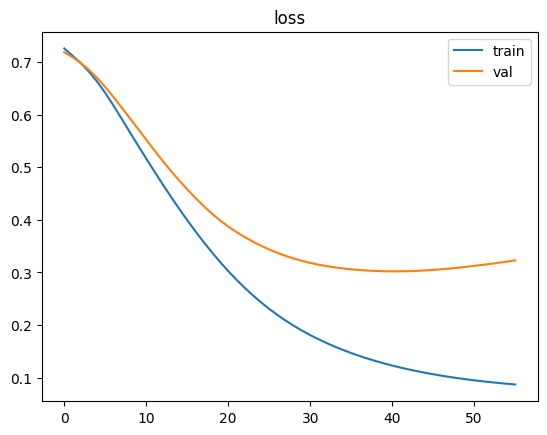

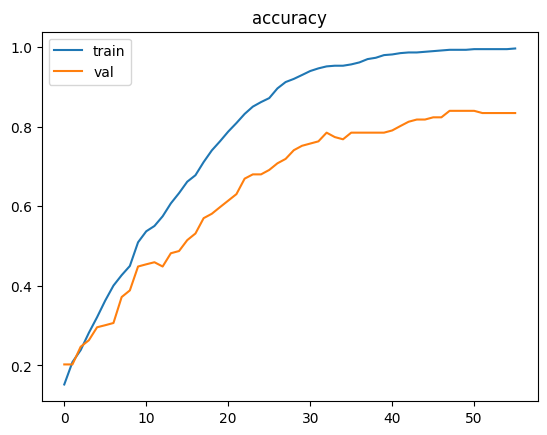

In [308]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [309]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.17394309423186563
train_accuracy: 0.931293709711595
loss: 0.3123024119572206
accuracy: 0.8181818181818182


In [310]:
from deepmeg.interpreters import LFCNNInterpreter
from copy import deepcopy

class CSPFBInterpreter(LFCNNInterpreter):
    @torch.no_grad()
    def compute_patterns(self):
        x, y = next(iter(DataLoader(self.dataset, len(self.dataset))))
        x_flatten = x.reshape(x.shape[1], x.shape[0]*x.shape[-1])
        latent_sources = self.model.unmixing_layer(x.permute(0, -1, 1)).permute(0, -1, 1)
        latent_sources_filtered = self.model.temp_conv(latent_sources)
        latent_sources_flatten = latent_sources_filtered.permute(1, 0, -1)
        latent_sources_flatten = latent_sources_flatten.reshape(latent_sources_flatten.shape[0], latent_sources_flatten.shape[1]*latent_sources_flatten.shape[2])
        self._latent_sources = latent_sources.numpy()
        self._latent_sources_filtered = latent_sources_filtered.numpy()
        unmixing_matrix = self.model.unmixing_layer.weight.numpy()
        filters = unmixing_matrix.T
        # covariance of latent_sources should aim to I, due to linear independance
        x = x.permute(1, 0, -1)
        x_flatten = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
        patterns = list()

        for comp_num in range(len(self.model.unmixing_layer.weight)):
            x_filt_flatten = torch.zeros_like(x_flatten)

            for ch_num in range(x.shape[0]):

                x_filt_flatten[ch_num] = torch.nn.functional.conv1d(
                    torch.unsqueeze(x_flatten[ch_num], 0),
                    torch.unsqueeze((
                        self.model.temp_conv.weight[comp_num]*self.model.temp_conv.window[comp_num]
                        ).detach(), 0),
                    padding='same'
                )
            patterns.append(torch.cov(x_filt_flatten)@self.model.unmixing_layer.weight[comp_num])

        patterns = torch.squeeze(torch.stack(patterns, 1))@torch.pinverse(torch.cov(latent_sources_flatten))


        return patterns.numpy(), filters

    @torch.no_grad()
    def compute_branchwise_loss(self):
        """
        This method computes the branchwise loss for each branch of LF-CNN (branch consits of two connected spatial and temporal filters).
        It computes loss of each branch by subtracting loss of original model from loss of the same model without nth branch.
        It is one of the easiest ways to estimate relevance of the branch.

        Returns:
            numpy.ndarray: A 1-dimensional numpy array of shape (n_latent, ) where n_latent is the number of branches in the model.
        """
        loader = DataLoader(self.dataset, len(self.dataset))
        base_loss = self.model.evaluate(loader)['loss']
        n_latent = self.model.unmixing_layer.weight.shape[0]

        losses = list()
        for i in range(n_latent):
            branch_unmixing_weights_original = deepcopy(self.model.unmixing_layer.weight[i, :])
            self.model.unmixing_layer.weight[i, :] = 0

            if self.model.unmixing_layer.bias is not None:
                branch_unmixing_bias_original = deepcopy(self.model.unmixing_layer.bias[i])
                self.model.unmixing_layer.bias[i] = 0
            if self.model.temp_conv.bias is not None:
                branch_temp_conv_bias_original = deepcopy(self.model.temp_conv.bias[i])
                self.model.temp_conv.bias[i] = 0

            losses.append(self.model.evaluate(loader)['loss'])
            self.model.unmixing_layer.weight[i, :] = branch_unmixing_weights_original

            if self.model.unmixing_layer.bias is not None:
                self.model.unmixing_layer.bias[i] = branch_unmixing_bias_original
            if self.model.temp_conv.bias is not None:
                self.model.temp_conv.bias[i] = branch_temp_conv_bias_original

        return base_loss - np.array(losses)

    @torch.no_grad()
    def compute_specta(self):
        """
        Compute the spectral parameters of temporal filters (model.temp_conv.weight, biases can be omitted due to linearity).

        Returns:
            frange (ndarray): The frequency range for the power spectral density.
            finputs (list): The power spectral density of the latent sources (spatially filtered data).
            fresponces (list): The absolute value of the frequency response of the filters.
                (FFT of the dephased Wiener filter).
            fpatterns (list): The product of the power spectral density and the absolute value of the frequency response.
                (spectral power density of the signal at the input of the Wiener optimal filter).
            foutputs (list): The product of the power spectral density and the squared magnitude of the frequency response.
                (spectral power density of the signal at the output of the digital filter).

        """
        filters = torch.squeeze(self.model.temp_conv.weight*self.model.temp_conv.window).detach().numpy()
        finputs, fresponces, fpatterns, foutputs = list(), list(), list(), list()
        frange = None

        for branch_num in range(self.latent_sources.shape[1]):
            lat_tc = self.latent_sources[:, branch_num, :]
            kern = filters[branch_num]
            frange, psd = sp.signal.welch(lat_tc, fs=self.info['sfreq'], nperseg=self.latent_sources.shape[-1])
            _, h = sp.signal.freqz(kern, 1, worN=self.latent_sources.shape[-1]//2 + 1)
            finputs.append(psd)
            fresponces.append(np.abs(h))
            fpatterns.append(finputs[-1]*fresponces[-1])
            foutputs.append(finputs[-1]*h*np.conj(h))

        return frange, finputs, fresponces, foutputs, fpatterns

In [312]:
interpreter = CSPFBInterpreter(model, dataset, info)

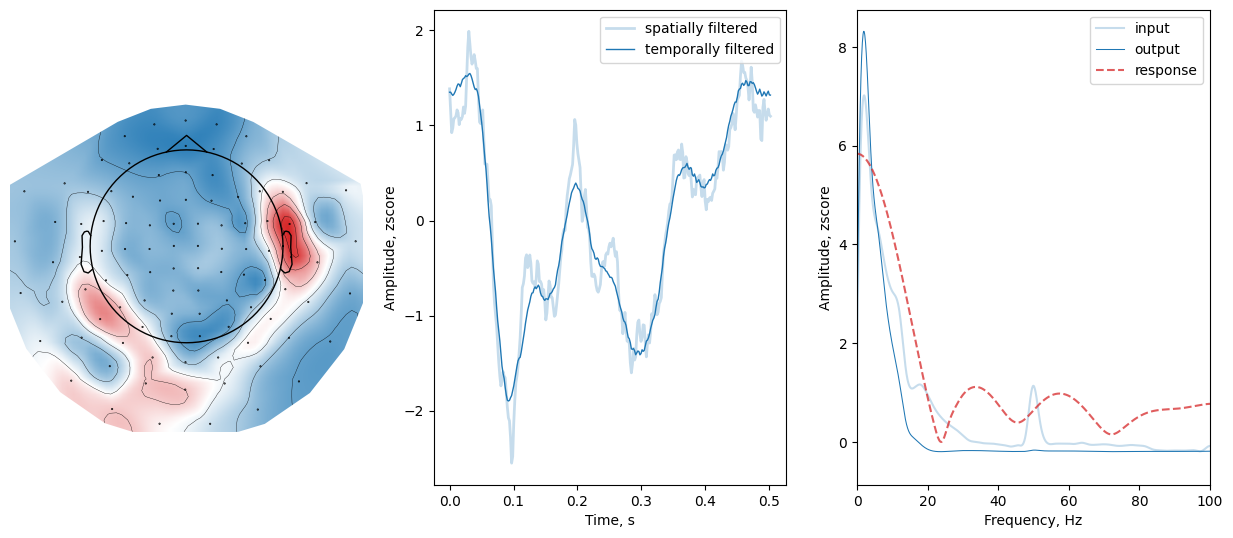

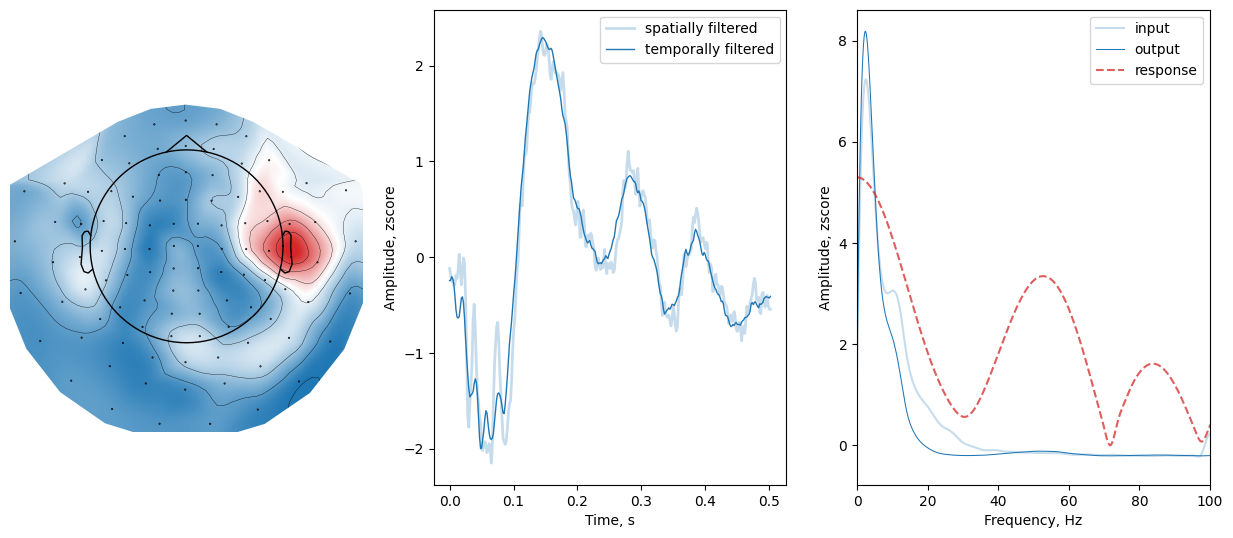

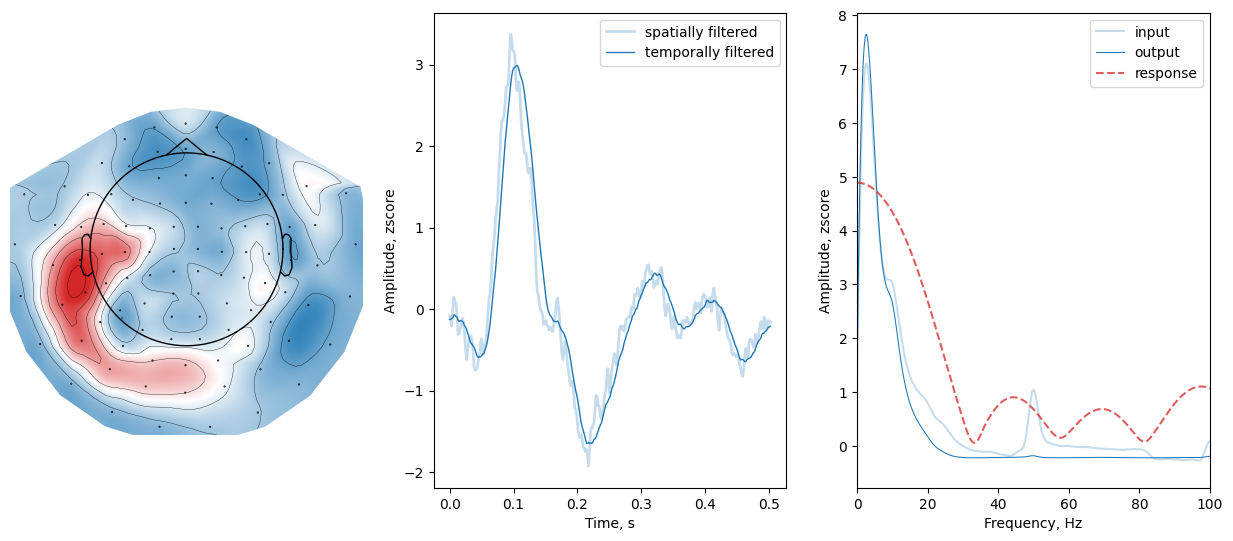

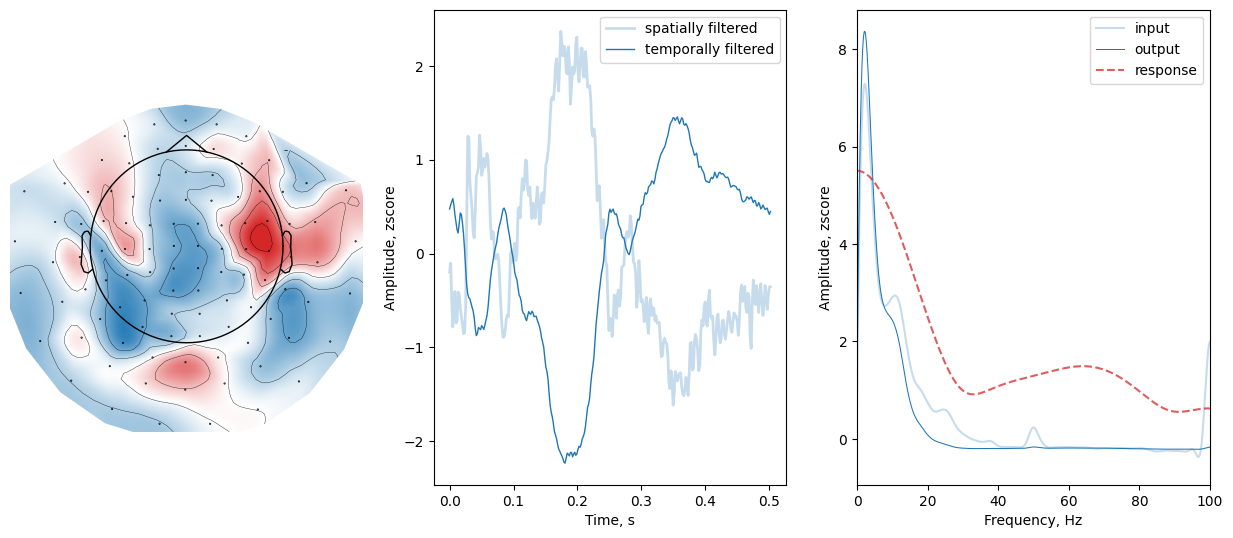

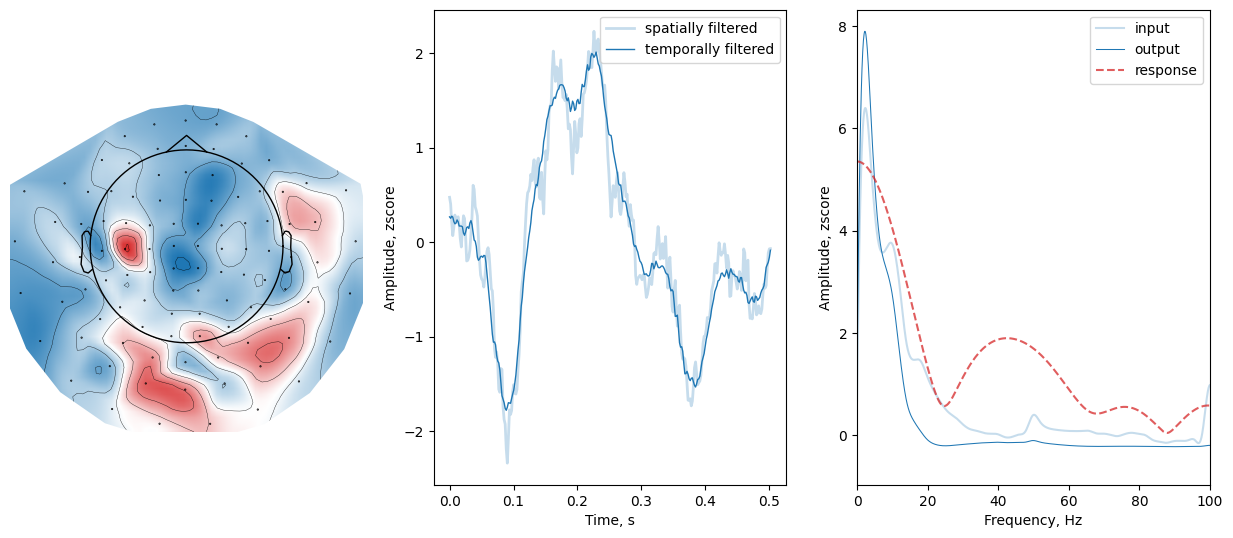

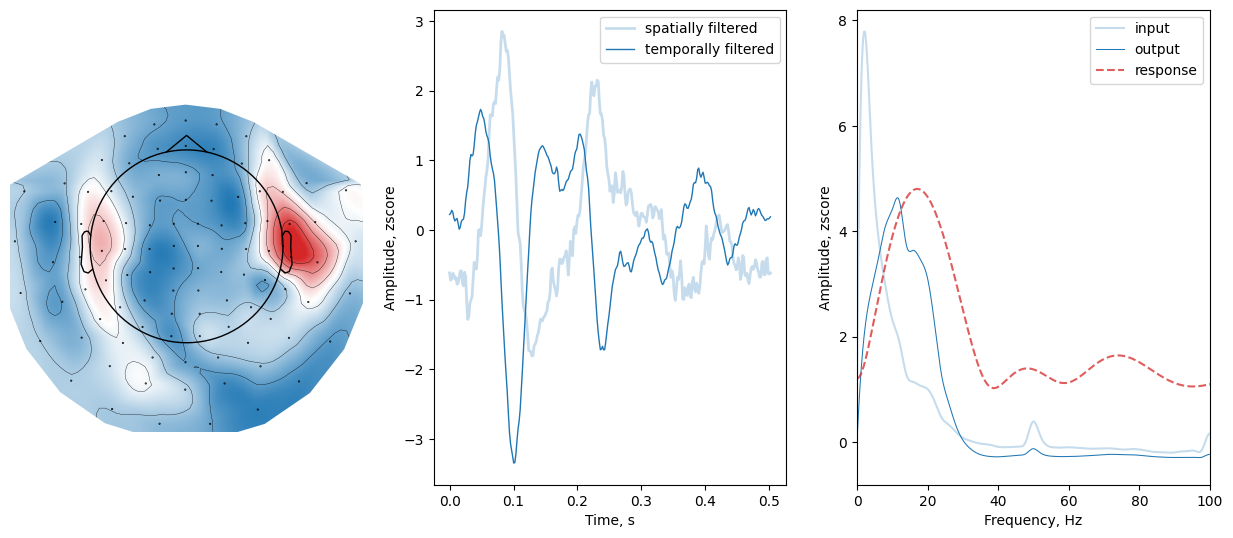

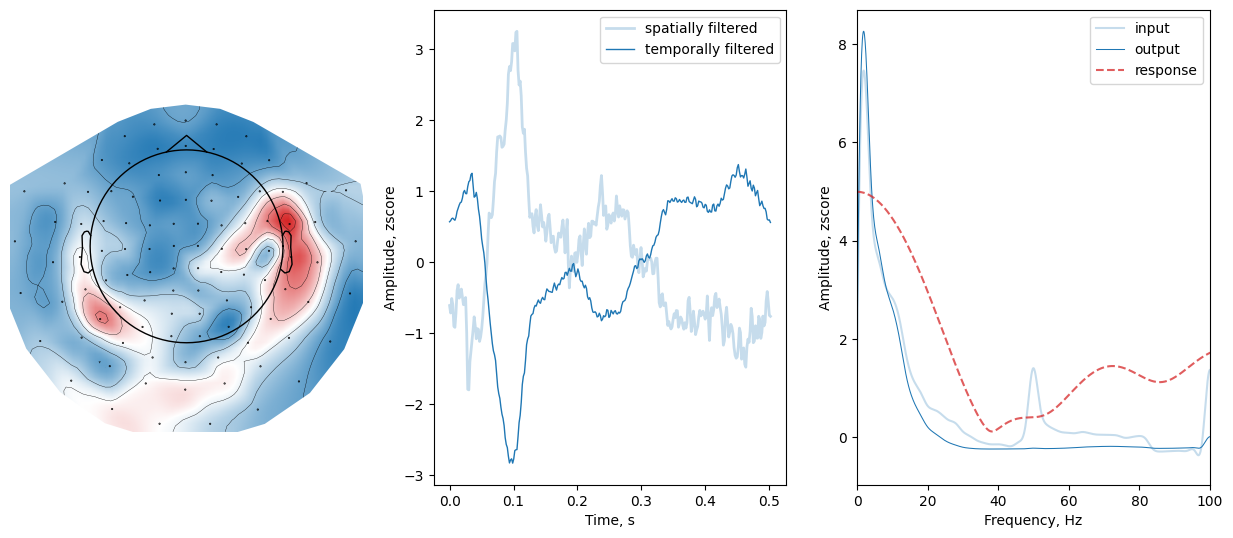

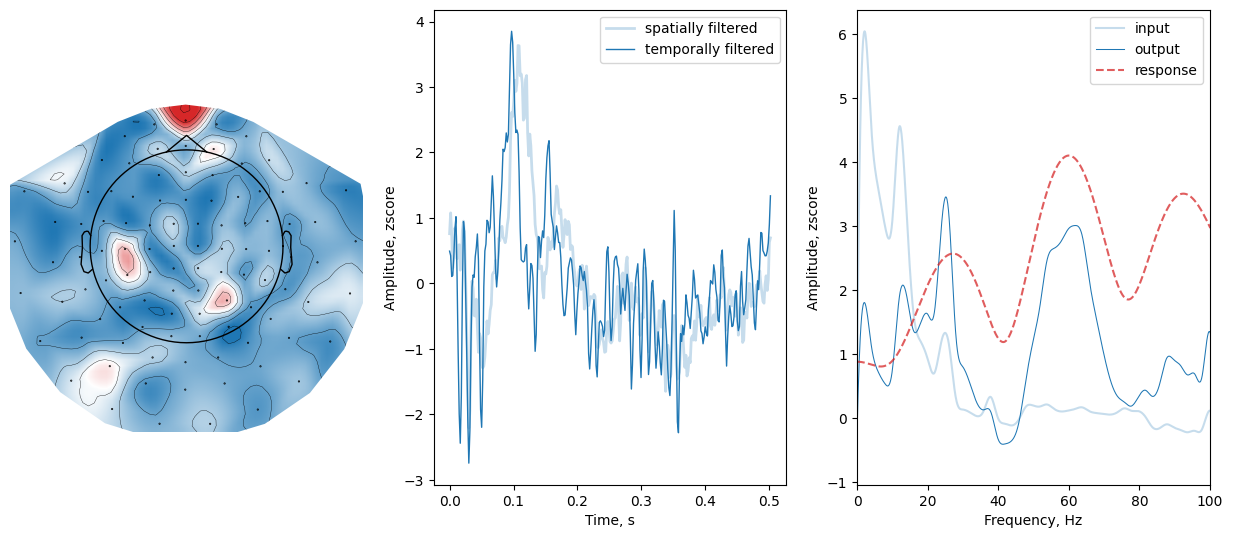

In [313]:
for i in range(8):
    fig = interpreter.plot_branch(i)